In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../bioseg")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_dir = '/data/natalia/intern20/PaperData/MIBI_2channel/'
pd_file = pd.read_csv(data_dir+'files.csv',index_col=0)
print(pd_file)

   prefix                                        input_dir  input_file  group
0  image0  /data/natalia/intern20/PaperData/MIBI_2channel/  image0.npz  train
1  image1  /data/natalia/intern20/PaperData/MIBI_2channel/  image1.npz  train
2  image2  /data/natalia/intern20/PaperData/MIBI_2channel/  image2.npz   test
3  image3  /data/natalia/intern20/PaperData/MIBI_2channel/  image3.npz   test


## Scribbles generation

In [11]:
## number of label's scribbles
nlabels_objecttype = [35,35,30] #cytoplasm, nuclei in cytoplasm, nuclei out of cytoplasm
nlabels_budget = np.sum(nlabels_objecttype)
print(nlabels_budget)

100


/data/natalia/intern20/PaperData/MIBI_2channel/image0.npz


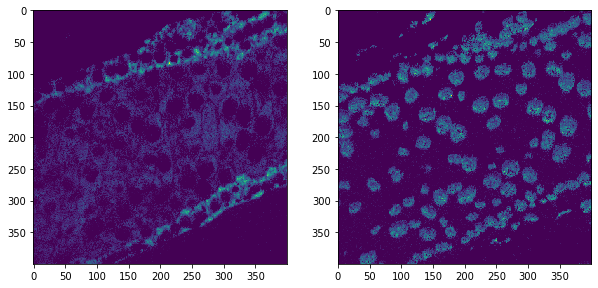

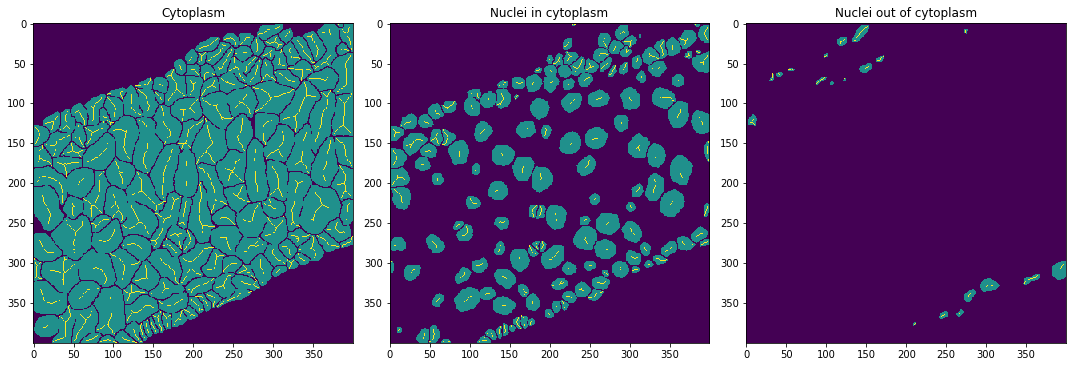

/data/natalia/intern20/PaperData/MIBI_2channel/image1.npz


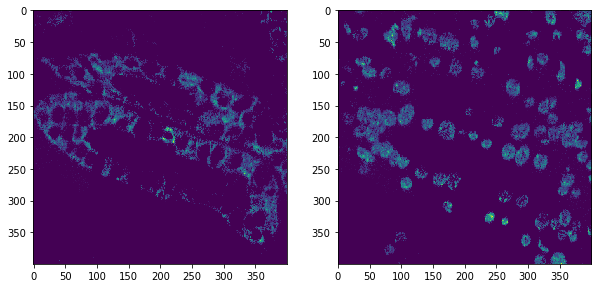

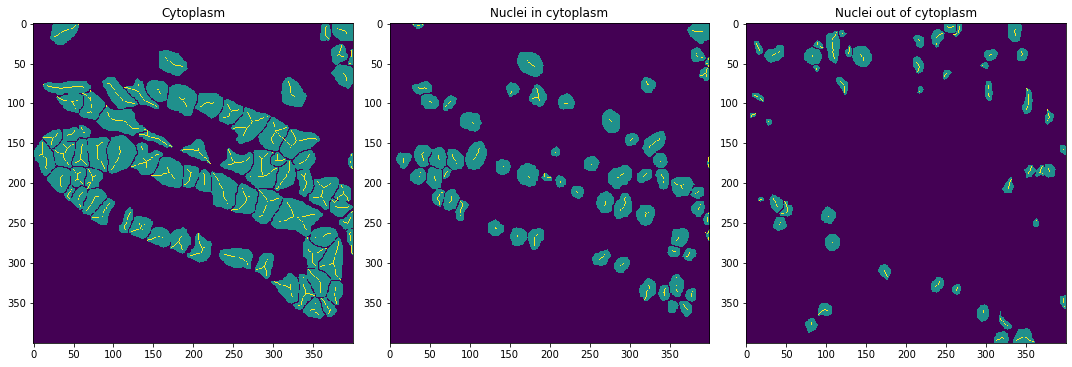

In [12]:
from skimage import morphology
from BioSeg_labelgenerator import get_scribbles

#load train segmentations in a list
X_train_list = []

Y_gt_train_ch0_list = []
Y_gt_train_ch1_list = []
Y_gt_train_ch2_list = []
Y_gt_train_list = []

files_train_list_aux = []

nlabels_total0 = 0
nlabels_total1 = 0
nlabels_total2 = 0

for i in range(len(pd_file)):
    group = pd_file['group'][i]
    if group == 'train':

        print(pd_file['input_dir'][i] + pd_file['input_file'][i])
        npz_read = np.load(pd_file['input_dir'][i] + pd_file['input_file'][i])
        image = npz_read['image']
        label0 = npz_read['label_aux'][...,0]
        label1 = npz_read['label_aux'][...,1]
        label2 = npz_read['label_aux'][...,2]
        
        
        label0_gt = npz_read['label'][...,0]
        label1_gt = npz_read['label'][...,1]
        label2_gt = npz_read['label'][...,2]
        
        nlabels_total0 += np.unique(label0).shape[0]-1
        nlabels_total1 += np.unique(label1).shape[0]-1
        nlabels_total2 += np.unique(label2).shape[0]-1
        
        X_train_list.append(image)
        Y_gt_train_ch0_list.append(label0)
        Y_gt_train_ch1_list.append(label1)
        Y_gt_train_ch2_list.append(label2)
        Y_gt_train_list.append([label0_gt,label1_gt,label2_gt])
        
        files_train_list_aux.append([pd_file['input_dir'][i],
                                 pd_file['input_file'][i],
                                 pd_file['prefix'][i],])

        #nuclei mask
        nuclei0 = np.zeros_like(label0)
        nuclei0[label0>0] = 1
        
        nuclei1 = np.zeros_like(label1)
        nuclei1[label1>0] = 1
        
        nuclei2 = np.zeros_like(label2)
        nuclei2[label2>0] = 1

        plt.figure(figsize=(10,5))
        
        plt.subplot(1,2,1)
        plt.imshow(image[...,0])
        
        plt.subplot(1,2,2)
        plt.imshow(image[...,1])
        
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        skeleton = morphology.skeletonize(nuclei0)
        plt.title('Cytoplasm')
        plt.imshow(nuclei0+skeleton)

        plt.subplot(1,3,2)
        skeleton = morphology.skeletonize(nuclei1)
        plt.title('Nuclei in cytoplasm')
        plt.imshow(nuclei1+skeleton)
        
        plt.subplot(1,3,3)
        skeleton = morphology.skeletonize(nuclei2)
        plt.title('Nuclei out of cytoplasm')
        plt.imshow(nuclei2+skeleton)
        
        plt.tight_layout()
#         plt.axes(off)
        plt.show()

In [13]:


### Cytoplasm scribbles (ch0)
Y_out_ch0_list_c, nscribbles_ch0_list_c, nlabels_ch0_list_c = get_scribbles(Y_gt_train_ch0_list,
                                                                     nlabels_objecttype[0],
                                                                     fov_box=(32,32),
                                                                     radius_pointer=0,
                                                                     disk_scribble = True,
                                                                     sample_back = True)

### Nuclei in cytoplasm scribbles (ch1)
Y_out_ch1_list_c, nscribbles_ch1_list_c, nlabels_ch1_list_c = get_scribbles(Y_gt_train_ch1_list,
                                                                     nlabels_objecttype[1],
                                                                     fov_box=(32,32),
                                                                     radius_pointer=0,
                                                                     disk_scribble = False,
                                                                     sample_back = False)
nlabels_total_budget = nlabels_budget + 0
nlabels_total_budget -= (np.sum(nscribbles_ch1_list_c) + np.sum(nscribbles_ch0_list_c))

### Nuclei out of cytoplasm scribbles (ch2)
Y_out_ch2_list_c, nscribbles_ch2_list_c, nlabels_ch2_list_c = get_scribbles(Y_gt_train_ch2_list,
                                                                     nlabels_total_budget,
                                                                     fov_box=(32,32),
                                                                     radius_pointer=0,
                                                                     disk_scribble = False,
                                                                     sample_back = False)

sample,nbudget,nscribbles
0 35 17
1 18 18
sample,nbudget,nscribbles
0 35 17
1 16 16
sample,nbudget,nscribbles
0 28 14
1 13 13


In [16]:
### Merge Channels into:
# ch0: only cytoplasm
# ch1: nuclei (nuclei in and out cytoplasm)
# ch2: cytoplasm + nuclei out of cytoplasm

Y_out_ch0_list = []
Y_out_ch1_list = []
Y_out_ch2_list = []

ix = 0
for ix in range(len(Y_gt_train_list)):
    
    
    mask_Dapi = Y_gt_train_list[ix][0]+0
    mask_Dapi[mask_Dapi>0] = 1
    mask_Dapi_PanCK_2 = Y_gt_train_list[ix][2]+0
    mask_Dapi_PanCK_2[mask_Dapi_PanCK_2>0] = 1
    
    #Cytoplasm channel
    Y_comb_ch00 = np.zeros_like(Y_out_ch0_list_c[ix])
    Y_comb_ch00[...,0] = Y_out_ch0_list_c[ix][...,0]
    #fore ch2 (nuclei out of cytoplasm) is back on cytoplasm only channel: 
    Y_comb_ch00[...,2] = Y_out_ch0_list_c[ix][...,2] + Y_out_ch2_list_c[ix][...,0]*(1-mask_Dapi) 
    Y_comb_ch00[...,1] = Y_out_ch0_list_c[ix][...,1]
    Y_comb_ch00[Y_comb_ch00>0] = 1
    Y_out_ch0_list.append(Y_comb_ch00)
    
    #Cytoplasm + nuclei out of cytoplasm: Integration channel 0 and channel 2 
    Y_comb_ch02 = np.zeros_like(Y_out_ch0_list_c[ix])
    Y_comb_ch02[...,0] = Y_out_ch0_list_c[ix][...,0] + Y_out_ch2_list_c[ix][...,0]
    Y_comb_ch02[Y_comb_ch02>0] = 1
    Y_comb_ch02[...,1] = Y_out_ch0_list_c[ix][...,1]*(1-mask_Dapi_PanCK_2) + Y_out_ch2_list_c[ix][...,1]*(1-mask_Dapi)
    Y_comb_ch02[...,1] = Y_comb_ch02[...,1]*(1-Y_comb_ch02[...,0])
    Y_comb_ch02[Y_comb_ch02>0] = 1
    Y_comb_ch02[...,2] = Y_out_ch0_list_c[ix][...,2]*(1-mask_Dapi_PanCK_2) + Y_out_ch2_list_c[ix][...,2]*(1-mask_Dapi)
    Y_comb_ch02[...,2] = Y_comb_ch02[...,2]*(1-Y_comb_ch02[...,0])*(1-Y_comb_ch02[...,1])
    Y_comb_ch02[Y_comb_ch02>0] = 1
    Y_out_ch2_list.append(Y_comb_ch02)
    
    mask_PanCK = Y_gt_train_list[ix][1] + 0
    mask_PanCK[mask_PanCK>0] = 1
    
    #nuclei: Integration channel 1 and channel 2 (nuclei in cytoplasm + nuclei out of cytoplasm)
    Y_comb_ch12 = np.zeros_like(Y_out_ch1_list_c[ix])
    Y_comb_ch12[...,0] = Y_out_ch1_list_c[ix][...,0] + Y_out_ch2_list_c[ix][...,0]
    Y_comb_ch12[Y_comb_ch12>0] = 1
    Y_comb_ch12[...,1] = Y_out_ch1_list_c[ix][...,1]+ Y_out_ch2_list_c[ix][...,1]*(1-mask_PanCK)
    Y_comb_ch12[...,1] = Y_comb_ch12[...,1]*(1-Y_comb_ch12[...,0])
    Y_comb_ch12[Y_comb_ch12>0] = 1
    Y_comb_ch12[...,2] = Y_out_ch1_list_c[ix][...,2]+ Y_out_ch2_list_c[ix][...,2]*(1-mask_PanCK)
    Y_comb_ch12[...,2] = Y_comb_ch12[...,2]*(1-Y_comb_ch12[...,0])*(1-Y_comb_ch12[...,1])
    Y_comb_ch12[Y_comb_ch12>0] = 1
    Y_out_ch1_list.append(Y_comb_ch12)
    

0 ['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image0.npz', 'image0']
CHANNEL 0: Cytoplasm


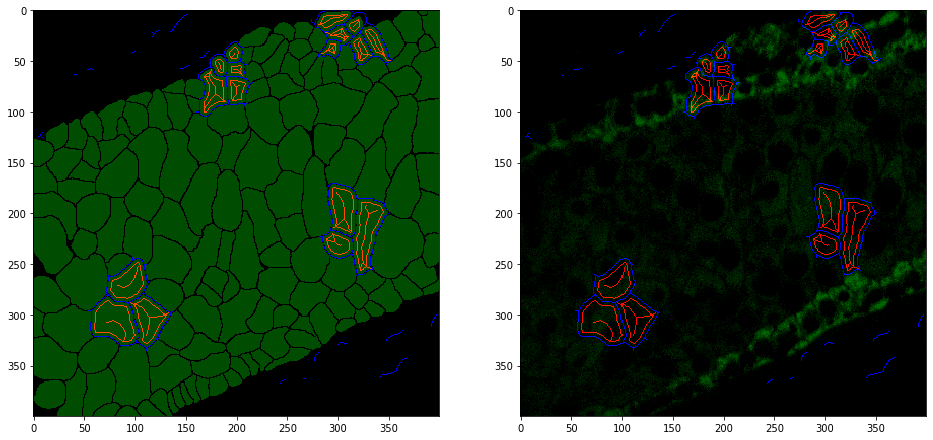

['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image0.npz', 'image0']
CHANNEL 1: Nuclei


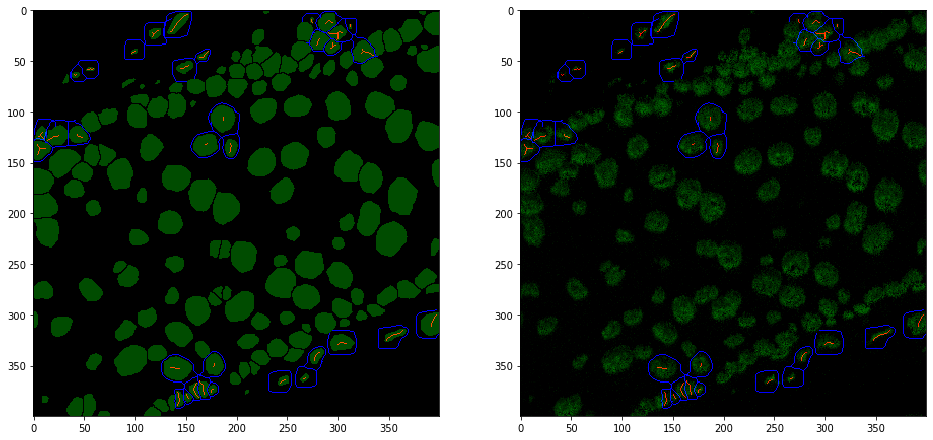

['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image0.npz', 'image0']
CHANNEL 2: Cytoplasm + nuclei out of cytoplasm


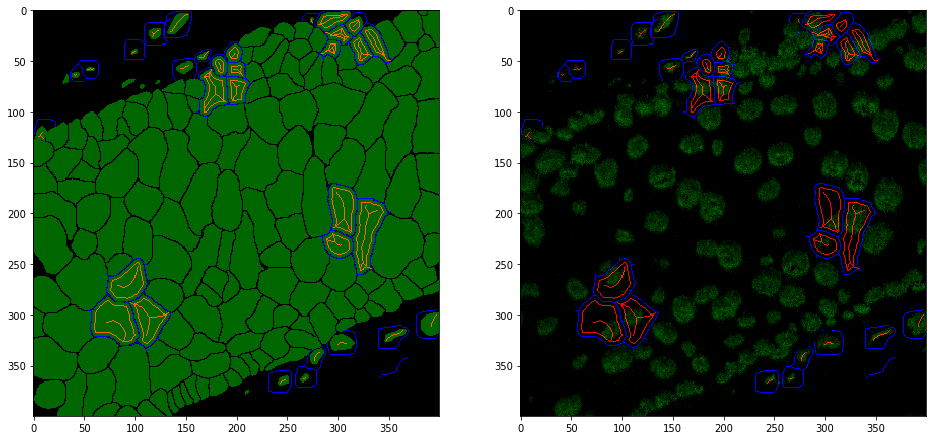

Y OUT UNIQUE ::  [0. 1.]
image0_scribble_n100.npz
1 ['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image1.npz', 'image1']
CHANNEL 0: Cytoplasm


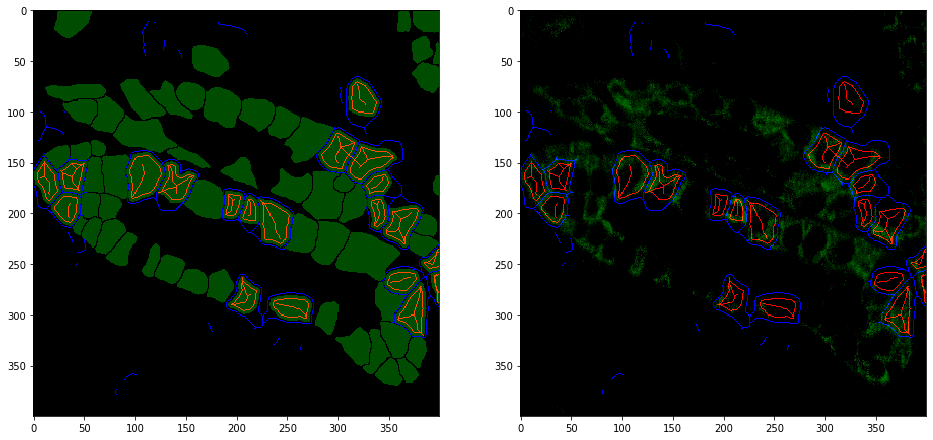

['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image1.npz', 'image1']
CHANNEL 1: Nuclei


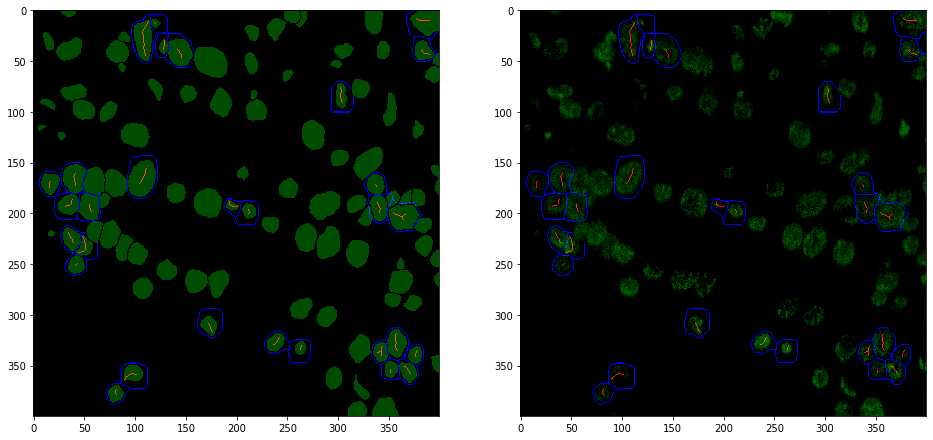

['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image1.npz', 'image1']
CHANNEL 2: Cytoplasm + nuclei out of cytoplasm


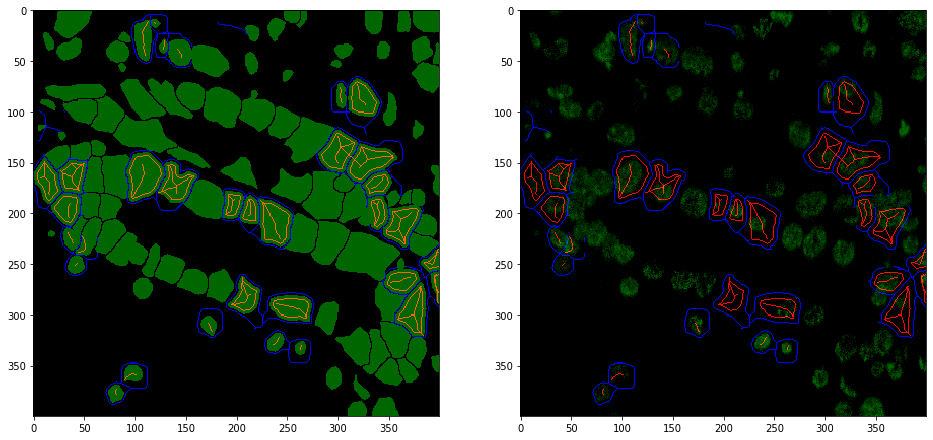

Y OUT UNIQUE ::  [0. 1.]
image1_scribble_n100.npz


In [19]:
## Save scribbles

import copy
from csbdeep.utils import normalize

files_train_list = copy.deepcopy(files_train_list_aux)

for i in range(len(Y_out_ch1_list)):
    
    ## CHANNEL 0 ##
    image = X_train_list[i][...,0]
    image_plot = normalize(image,pmin=1,pmax=99.8,clip = True)
    label0 = Y_gt_train_ch0_list[i]
    
    print(i,files_train_list[i])
    
    nuclei = np.zeros_like(label0)
    nuclei[label0>0] = 1
    
    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = nuclei*0.3
    aux[...,0] = Y_out_ch0_list[i][...,0]
    aux[...,2] = np.sum(Y_out_ch0_list[i][...,1:],axis = 2)
    
    print('CHANNEL 0: Cytoplasm')
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(aux)


    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = image_plot[...]*0.4
    aux[...,0] = Y_out_ch0_list[i][...,0]
    aux[...,2] = np.sum(Y_out_ch0_list[i][...,1:],axis = 2)

    plt.subplot(1,2,2)
    plt.imshow(aux)
    plt.show()
    
    ## CHANNEL 1 ##
    image = X_train_list[i][...,1]
    image_plot = normalize(image,pmin=1,pmax=99.8,clip = True)
    label1 = Y_gt_train_ch1_list[i] + Y_gt_train_ch2_list[i]
    
    print(files_train_list[i])
    
    print('CHANNEL 1: Nuclei')
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    
    nuclei = np.zeros_like(label1)
    nuclei[label1>0] = 1
    
    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = nuclei*0.3
    aux[...,0] = Y_out_ch1_list[i][...,0]
    aux[...,2] = np.sum(Y_out_ch1_list[i][...,1:],axis = 2)
    
    plt.imshow(aux)


    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = image_plot[...]*0.4
    aux[...,0] = Y_out_ch1_list[i][...,0]
    aux[...,2] = np.sum(Y_out_ch1_list[i][...,1:],axis = 2)

    plt.subplot(1,2,2)
    plt.imshow(aux)
    plt.show()
    
    
    
    ## CHANNEL 2 ##
    image = X_train_list[i][...,0]
    image_plot = normalize(image,pmin=1,pmax=99.8,clip = True)
    label2 = Y_gt_train_ch2_list[i] + Y_gt_train_ch0_list[i]
    
    print(files_train_list[i])
    
    print('CHANNEL 2: Cytoplasm + nuclei out of cytoplasm')
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    
    nuclei = np.zeros_like(label2)
    nuclei[label2>0] = 1
    
    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = nuclei*0.4
    aux[...,0] = Y_out_ch2_list[i][...,0]
    aux[...,2] = np.sum(Y_out_ch2_list[i][...,1:],axis = 2)
    
    plt.imshow(aux)
    
    image = X_train_list[i][...,1]
    image_plot = normalize(image,pmin=1,pmax=99.8,clip = True)

    aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
    aux[...,1] = image_plot[...]*0.4
    aux[...,0] = Y_out_ch2_list[i][...,0]
    aux[...,2] = np.sum(Y_out_ch2_list[i][...,1:],axis = 2)

    plt.subplot(1,2,2)
    plt.imshow(aux)
    plt.show()

    
    Y_out = np.concatenate([Y_out_ch0_list[i],
                           Y_out_ch1_list[i],
                           Y_out_ch2_list[i]],axis = -1)
    
    print('Y OUT UNIQUE :: ',np.unique(Y_out.flatten()))
    name_save = files_train_list[i][1].split('.')[0] + '_scribble_n'+str(int(nlabels_budget))+'.npz'
    print(name_save)
    np.savez(files_train_list[i][0]+name_save,scribble=Y_out)
    
    files_train_list[i].extend([name_save,int(len(np.unique(label0))),int(nscribbles_ch0_list_c[i]),
                                int(len(np.unique(label1))),int(nscribbles_ch1_list_c[i]),
                                int(len(np.unique(label2))),int(nscribbles_ch2_list_c[i])])

In [22]:
pd_scribbles = pd.DataFrame(data=files_train_list,columns=['input_dir','input_file','prefix',
                                                           'scribble_file','total_labels_ch0','scribble_labels_ch0',
                                                          'total_labels_ch1','scribble_labels_ch1',
                                                          'total_labels_ch2','scribble_labels_ch2'])
print(pd_scribbles)

print('Saving in: ')
print(data_dir+'files_scribbles_train_'+str(int(nlabels_budget))+'.csv')
pd_scribbles.to_csv(data_dir+'files_scribbles_train_'+str(int(nlabels_budget))+'.csv',index=None)


                                         input_dir  input_file  prefix  \
0  /data/natalia/intern20/PaperData/MIBI_2channel/  image0.npz  image0   
1  /data/natalia/intern20/PaperData/MIBI_2channel/  image1.npz  image1   

              scribble_file  total_labels_ch0  scribble_labels_ch0  \
0  image0_scribble_n100.npz               161                   17   
1  image1_scribble_n100.npz                73                   19   

   total_labels_ch1  scribble_labels_ch1  total_labels_ch2  \
0               153                   19               161   
1                62                   17                78   

   scribble_labels_ch2  
0                   15  
1                   13  
Saving in: 
/data/natalia/intern20/PaperData/MIBI_2channel/files_scribbles_train_100.csv


## Dataset patches generation

In [23]:
pd_scribbles = pd.read_csv(data_dir+'files_scribbles_train_'+str(int(nlabels_budget))+'.csv')
pd_scribbles

,input_dir,input_file,prefix,scribble_file,total_labels_ch0,scribble_labels_ch0,total_labels_ch1,scribble_labels_ch1,total_labels_ch2,scribble_labels_ch2
0,/data/natalia/intern20/PaperData/MIBI_2channel/,image0.npz,image0,image0_scribble_n100.npz,161,17,153,19,161,15
1,/data/natalia/intern20/PaperData/MIBI_2channel/,image1.npz,image1,image1_scribble_n100.npz,73,19,62,17,78,13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:00<00:00, 65.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


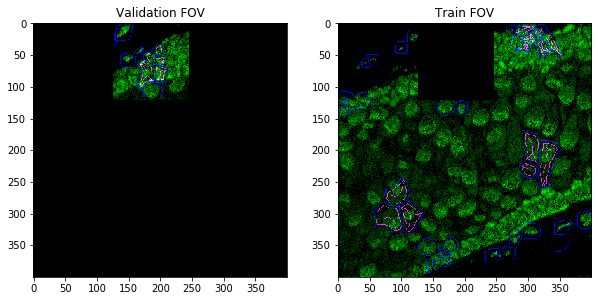

100%|██████████| 1/1 [00:00<00:00, 45.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 1/1 [00:00<00:00, 67.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


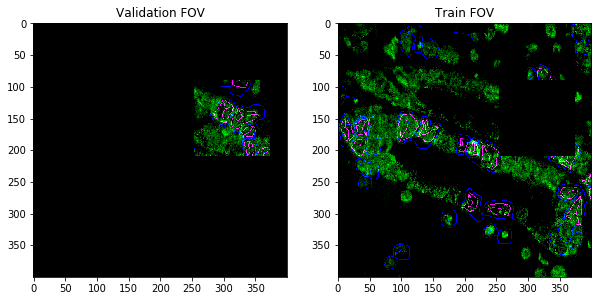

100%|██████████| 1/1 [00:00<00:00, 44.83it/s]

(60, 128, 128, 9) (16, 128, 128, 9)


In [35]:
from BioSeg_labelgenerator import get_dataset

n_patches_per_image_train=30
n_patches_per_image_val=8
patch_size=(128, 128)
p_label = 0.6
val_perc = 0.3
verbose = True

X_train,Y_train,X_val,Y_val = get_dataset(pd_scribbles,n_patches_per_image_train=n_patches_per_image_train,
                                          n_patches_per_image_val=n_patches_per_image_val,patch_size=patch_size,
                                          p_label = p_label,val_perc = val_perc,verbose = verbose)


In [36]:
print(Y_train.shape)

(60, 128, 128, 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train size (X,Y)
(60, 128, 128, 2) (60, 128, 128, 6)
Val size (X,Y)
(16, 128, 128, 2) (16, 128, 128, 6)
Patches with at least one label:
Train:,  60
Val:,  16
-----------------------  Random Patches -----------------------
Channel 2
Train


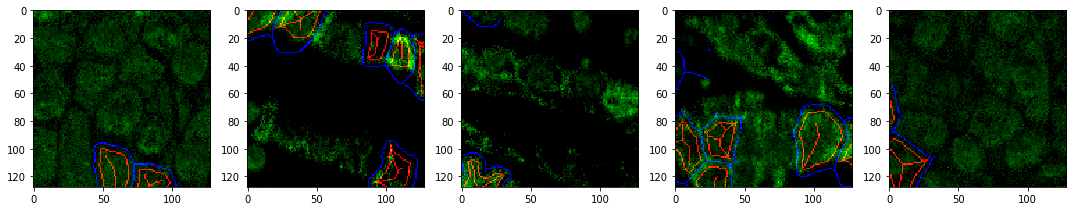

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation


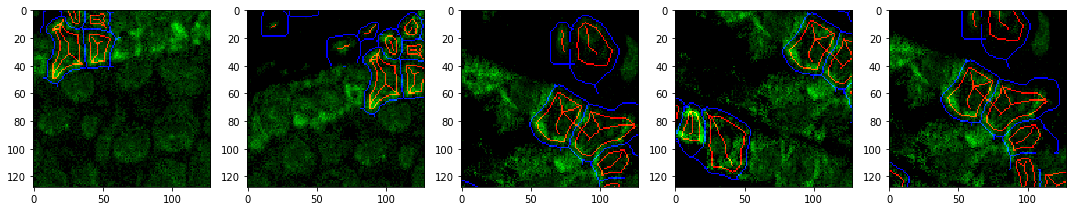

In [53]:
print('Train size (X,Y)')
print(X_train.shape,Y_train.shape)
print('Val size (X,Y)')
print(X_val.shape,Y_val.shape)
print('Patches with at least one label:')
print('Train:, ', np.sum(np.sum(Y_train,axis = (1,2,3))>0))
print('Val:, ', np.sum(np.sum(Y_val,axis = (1,2,3))>0))

################# PLOT RANDOM PATCHES #################
ix_1 = 2 ## Channel selection (0 cytoplasm, 1 nuclei, 2 cytoplasm + nuclei out of cytoplasm)

print('-----------------------  Random Patches -----------------------')
print('Channel '+ str(ix_1))

print('Train')
index = np.arange(Y_train.shape[0])
np.random.shuffle(index)
cont = 1
plt.figure(figsize = (15,4))
for ix in index[0:5]:
    img_plot = np.concatenate([Y_train[ix,:,:,2*ix_1][...,np.newaxis],
                               0.7*X_train[ix,:,:,0][...,np.newaxis]+ 0.4*X_train[ix,:,:,1][...,np.newaxis],
                               Y_train[ix,:,:,2*ix_1+1][...,np.newaxis]],axis = -1)
    
    plt.subplot(1,5,cont)
    cont += 1
    plt.imshow(img_plot)
plt.tight_layout()
plt.show()

print('Validation')
index = np.arange(Y_val.shape[0])
np.random.shuffle(index)
cont = 1
plt.figure(figsize = (15,4))
for ix in index[0:5]:
    img_plot = np.concatenate([Y_val[ix,:,:,2*ix_1][...,np.newaxis],
                               0.7*X_val[ix,:,:,0][...,np.newaxis] + 0.4*X_val[ix,:,:,1][...,np.newaxis],
                               Y_val[ix,:,:,2*ix_1+1][...,np.newaxis]],axis = -1)
    
    plt.subplot(1,5,cont)
    cont += 1
    plt.imshow(img_plot)
plt.tight_layout()
plt.show()


In [55]:
data_save_file = data_dir+'dataset_mibi2ch_noaug_n'+str(int(nlabels_budget))+'.npz'
print(data_save_file)

/data/natalia/intern20/PaperData/MIBI_2channel/dataset_mibi2ch_noaug_n100.npz


In [57]:
np.savez(data_save_file, X_train=X_train, Y_train=Y_train.astype('int'),
         X_val=X_val, Y_val=Y_val.astype('int'))
print('saving dataset :: ', data_save_file)

saving dataset ::  /data/natalia/intern20/PaperData/MIBI_2channel/dataset_mibi2ch_noaug_n100.npz
